# 304.3. Weak lensing with Abell 360

<div style="max-width:300px; float: left; margin-right: 1em">

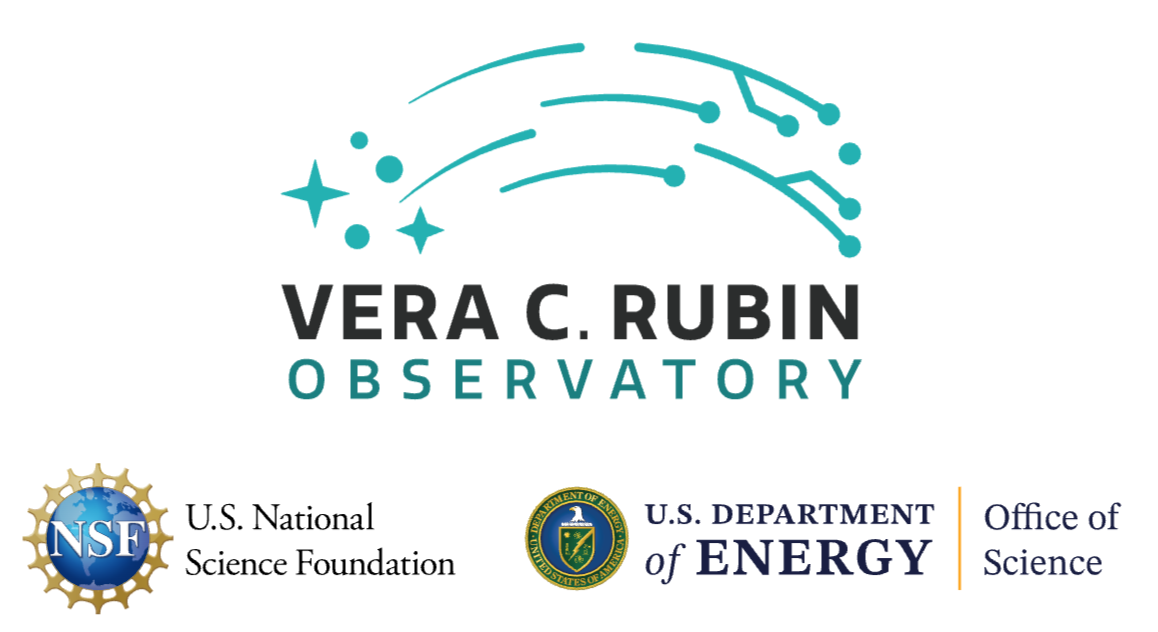

</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: Release r29.1.1 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** Evaluate the weak lensing effect of galaxy cluster Abell 360 (A360) on background galaxies.

**LSST data products:** `deep_coadd` images, `Object` table

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.afw.display`.

**Credit:**
Developed by Shenming Fu and the Rubin Community Science team., inspired by Céline Combet's and Prakruth Adari's Notebooks for [ComCam Clusters](https://github.com/lsst-sitcom/comcam_clusters). See also Tech Notes [C. Combet et al.,](https://sitcomtn-161.lsst.io/) and [P. Adari et al.](https://sitcomtn-163.lsst.io/). 
Part of this notebook will be used for a journal article about a Rubin view of A360 (led by Anja von der Linden).
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

Galaxy clusters are the largest gravitionally bound objects in the Universe.
According to the General Relatively, massive objects warp the spacetime, and light follows the curvature of spacetime.
Thus, massive objects act like lenses that bend the path of the light emitted from distance sources.
This effect is called "gravitional lensing". 

The large mass of a galaxy cluster coherently distorts the images of backgroud galaxies, and this distortion occurs over a large sky area around the cluster.
The lensing effect on the shape of a single background galaxy far from the cluster center is small, but the lensing signal can be detected by averaging the shape of many background galaxies.
This is because the original shapes of the galaxies are randomly oriented.
This effect is called weak gravitational lensing (WL), which shows up in the statistics of a large sample of galaxy shapes.
More detailed introduction to cluster WL can be found in review papers (e.g., [Bartelmann & Schneider 2001](https://ui.adsabs.harvard.edu/abs/2001PhR...340..291B/abstract); [Umetsu 2020](https://ui.adsabs.harvard.edu/abs/2020A%26ARv..28....7U/abstract)). 

Note that WL also happens between galaxies and when the light passes through the large-scale structure of the Universe (cosmic shear).
Compared to galaxy-galaxy lensing and cosmic shear, the cluster WL signal is generally about 1 magnitude higher (at the level of 10 times). 

Abell 360 (A360) is a known rich cluster (redshift=0.22) covered by DP1.
This notebook provides a demonstration of detecting the lensing signal with Abell 360 and DP1 data. 
First, find red sequence (RS) galaxies of A360 using color-magnitude diagrams (CMDs). Then, use galaxies redder than RS as the background sample. Next, visualize the galaxies in the coadded images. Finally, study the shape distribution of background galaxies. 

**Related tutorials:** The 100-level tutorials on using the butler and Table Access Protocol (TAP). The 200-level tutorials on object tables and deep coadds. Also, the DP02 notebook on galaxy cluster weak lensing (note some columns are updated in DP1).

### 1.1. Import packages

Import general packages (`numpy`, `matplotlib`, `astropy`), the LSST Science Pipelines packages for bulter and display, and Rubin Science Platform Table Access Protocol (TAP) package.

In [1]:
import numpy as np
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.afw.display as afwDisplay
from lsst import geom

### 1.2. Define parameters and functions
Set up Firefly for displaying images.

In [2]:
afwDisplay.setDefaultBackend("firefly")
afw_display = afwDisplay.Display(frame=1)

Get the butler via repo and collection.

In [3]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Get the TAP service.

In [4]:
service = get_tap_service("tap")
assert service is not None

## 2. Load data



The Brightest Cluster Galaxy (BCG) for Abell 360 has coordinates of Right Ascension (RA), DEClination (DEC) = 37.865, 6.982 deg.

In [5]:
ra_bcg = 37.865
dec_bcg = 6.982

Choose to load data obtained in the *i*-band filter for this lensing analysis. Using the `i` or `r` band shapes is common in weak lensing studies ([Mandelbaumet al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). The main reason is the balance between seeing and sky brightness for shape measurement ([Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...84F)). Another reason is that Differential Chromatic Refraction (DCR) is weaker in redder bands, which reduces the PSF elongation along the zenith and makes the galaxy's pre-PSF shape easier to measure ([Plazas et al. 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract)). 


In [6]:
band_shape = 'i'

### 2.1. Object table

Use the TAP service to make a cone search of the `Object` table for objects detected in the `deep_coadd` images within 0.4 degrees of the BCG. More details about the TAP service can be found in the DP1 tutorial Notebook for TAP (`100_How_to_Use_RSP_Tools/102_Catalog_access`).

Define the query to return shape parameters in the selected band, photometry in the *riz* bands, and other useful columns.

In [7]:
radius_deg = 0.4

query = "SELECT objectId, coord_ra, coord_dec, x, y, refExtendedness, " \
        f"{band_shape}_blendedness, " \
        f"{band_shape}_hsmShapeRegauss_e1, " \
        f"{band_shape}_hsmShapeRegauss_e2, " \
        f"{band_shape}_hsmShapeRegauss_sigma, " \
        f"{band_shape}_hsmShapeRegauss_flag, " \
        "r_cModelMag, i_cModelMag, z_cModelMag, " \
        "r_cModelMagErr, i_cModelMagErr, z_cModelMagErr, " \
        "r_cModelFlux/r_cModelFluxErr AS r_cModel_SNR, " \
        "i_cModelFlux/i_cModelFluxErr AS i_cModel_SNR, " \
        "z_cModelFlux/z_cModelFluxErr AS z_cModel_SNR, " \
        "r_cModel_flag, i_cModel_flag, z_cModel_flag " \
        "FROM dp1.Object " \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " \
        f"CIRCLE('ICRS', {ra_bcg}, {dec_bcg}, {radius_deg})) = 1 "

In [8]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [9]:
assert job.phase == 'COMPLETED'
obj_cat = job.fetch_result().to_table()
print(len(obj_cat))

112614


### 2.2. Deep coadd image

Use the butler to get the `deep_coadd` image in the `band_shape` filter that contains the BCG of Abell 360.

In [10]:
dataset_refs = butler.query_datasets("deep_coadd",
                                     where="band.name = band AND \
                                     patch.region OVERLAPS POINT(ra, dec)",
                                     bind={"band": band_shape,
                                           "ra": ra_bcg,
                                           "dec": dec_bcg})
for ref in dataset_refs:
    print(ref.dataId)

deep_coadd = butler.get(dataset_refs[0])

{band: 'i', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}


Display the image in the Firefly tab and set the mask to be transparent.

In [11]:
afw_display.mtv(deep_coadd)
afw_display.setMaskTransparency(100)

Mark the location of the BCG with a big orange circle.

In [12]:
wcs = deep_coadd.getWcs()
coord = geom.SpherePoint(ra_bcg*geom.degrees, dec_bcg*geom.degrees)
pixels = wcs.skyToPixel(coord)
afw_display.dot("o", pixels.getX(), pixels.getY(), size=100, ctype="orange")

## 3. Identify the background galaxies

To identify which galaxies are likely to be background galaxies, and include them in the weak lensing analysis,
starts by identifying which of the `Objects` are galaxies (and not stars), and which of the galaxies
are likely members of the cluster red sequence (RS). 

Clusters generally show a red sequence (RS) in the color-magnitude diagram (CMD) due to evolution -- those red galaxies are the oldest and reddest in the cluster ([Kodama and Arimoto 1997](https://ui.adsabs.harvard.edu/abs/1997A%26A...320...41K/abstract); [Gladders and Yee 2000](https://ui.adsabs.harvard.edu/abs/2000AJ....120.2148G/abstract)). Galaxies that are redder than the RS are background galaxies. Thus, use colors to select a sample of background galaxies, and a sample of bright cluster member galaxies -- they show different colors in the CMD. Here is also an example tutorial of using the Rubin Science Platform (RSP) Portal to study the RS ([Exploring Extended Object Populations with Histograms](https://dp0-2.lsst.io/tutorials-examples/portal-4.html)).

Note for simplicity, skip the use of photometric redshift (photo-z) in this notebook. While the photo-z information can help select background galaxies by redshift, background galaxies can also be selected directly by color.

### 3.1. Select galaxies

From the returned `Objects`, select the subset that are likely to be extended objects (galaxies, not stars)
using the `refExtendedness` column (0 for point-like, 1 for extended). This is the extendedness in the reference band. The extendness is the difference between the Point Spread Function (PSF) photometry and the Composite-Model (CModel) photometry ([Abazajian et al. 2004](https://ui.adsabs.harvard.edu/abs/2004AJ....128..502A/abstract), [Bosch et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract)). 

Select the objects that do not have flag parameters set to 1, to ensure the quality.

Use the *riz* `CModel` photometry [(Bosch et al. 2018)](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract),
which is appropriate for measurements of galaxies (extended objects), and retain only objects with signal-to-noise ratio SNR>5 to select well-detected objects..

In [13]:
band_list = ["r", "i", "z"]

sel = obj_cat["refExtendedness"] == 1
for band in band_list:
    sel &= obj_cat[f"{band}_cModel_flag"] == False
    sel &= obj_cat[f"{band}_cModel_SNR"] > 5.
obj_cat = obj_cat[sel]
print(len(obj_cat))

21975


### 3.2. Color-magnitude diagrams

Create color-magnitude diagrams (CMD) of galaxies. 
Consider three bands *riz*, and consider CMDs in colors *r-i* and *i-z*, where the RS is clear to see. 

Finding RS in multiple colors instead of a single color improves the determination of background galaxies ([Fu et al. 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...974...69F)). 


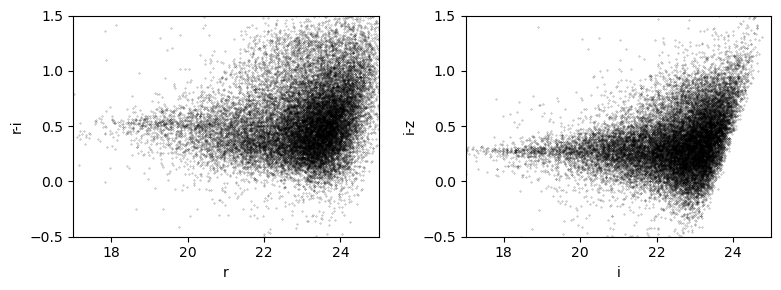

In [14]:
plt_dict = {0: ['r', 'i'], 1: ['i', 'z']}
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=False, sharex=False)
for i in [0, 1]:
    band1 = plt_dict[i][0]
    band2 = plt_dict[i][1]
    ax[i].scatter(obj_cat[band1+"_cModelMag"],
                  obj_cat[band1+"_cModelMag"] - obj_cat[band2+"_cModelMag"],
                  marker=".", s=0.3, alpha=0.5, color='k')
    ax[i].set_xlabel(band1)
    ax[i].set_ylabel(band1 + '-' + band2)
    ax[i].set_xlim([17, 25])
    ax[i].set_ylim([-0.5, 1.5])
plt.tight_layout()
plt.show()

> **Figure 1:** The color-magnitude diagram for all galaxies near Abell 360.

### 3.3. Cluster red sequence galaxies and background galaxies

Figure 1 shows that the red sequence (RS) is located approximately at `r-i`=0.5 and `i-z`=0.25, respectively, when the galaxies have different brightness (`r` or `i` band magnitude). That concentration represents the RS. 

To the CMD, add lines marking the RS, using a RS width of `eps` = 0.1 mag, and select RS galaxies (`sel_rs`).

Select background galaxies (`sel_bg`) as those redder than the RS. Allow some gap from the the RS because of magnitude measurement uncertainties.

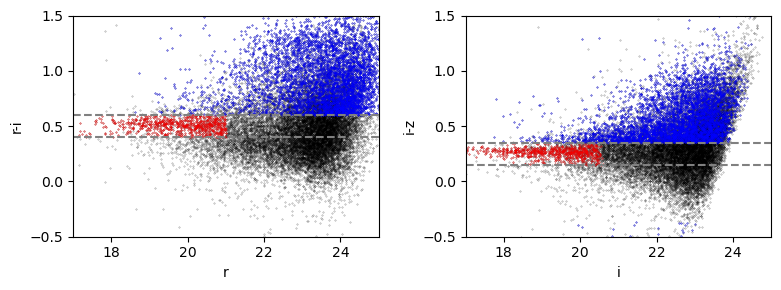

In [15]:
color_dict = {"ri": 0.5, "iz": 0.25}
eps = 0.1
sel_rs = np.array([True] * len(obj_cat))
sel_bg = np.array([True] * len(obj_cat))
mag_min = 17

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=False, sharex=False)
for i in [0, 1]:
    band1 = plt_dict[i][0]
    band2 = plt_dict[i][1]
    ax[i].scatter(obj_cat[band1+"_cModelMag"],
                  obj_cat[band1+"_cModelMag"] - obj_cat[band2+"_cModelMag"],
                  marker=".", s=0.3, alpha=0.5, color='k')

    color = color_dict[f"{band1}{band2}"]
    ax[i].axhline(color - eps, ls="--", color="grey", alpha=1)
    ax[i].axhline(color + eps, ls="--", color="grey", alpha=1)

    sel_bg &= np.abs(obj_cat[f"{band1}_cModelMag"] - obj_cat[f"{band2}_cModelMag"]) > (color + eps)
    sel_rs &= np.abs((obj_cat[f"{band1}_cModelMag"] - obj_cat[f"{band2}_cModelMag"]) - color) < eps

    ax[i].set_xlabel(band1)
    ax[i].set_ylabel(band1 + '-' + band2)
    ax[i].set_xlim([17, 25])
    ax[i].set_ylim([-0.5, 1.5])

for band in band_list:
    sel_bg &= obj_cat[f"{band}_cModelMag"] > mag_min
    sel_rs &= obj_cat[f"{band}_cModelMag"] < 21

for i in [0, 1]:
    band1 = plt_dict[i][0]
    band2 = plt_dict[i][1]
    ax[i].scatter(obj_cat[band1 + "_cModelMag"][sel_bg],
                  obj_cat[band1 + "_cModelMag"][sel_bg] - obj_cat[band2 + "_cModelMag"][sel_bg],
                  marker=".", s=0.3, alpha=1, color='blue')
    ax[i].scatter(obj_cat[band1 + "_cModelMag"][sel_rs],
                  obj_cat[band1 + "_cModelMag"][sel_rs] - obj_cat[band2 + "_cModelMag"][sel_rs],
                  marker=".", s=0.3, alpha=1, color='red')

plt.tight_layout()
plt.show()

> **Figure 2:** As in Figure 1, but with the RS marked with dashed lines and the background galaxies colored black.

### 3.4. Spatial distribution of galaxies

Plot the 2D distribution of the RS and background galaxies.
As expected, the RS galaxies are clustered and the background galaxies have a uniform distribution.

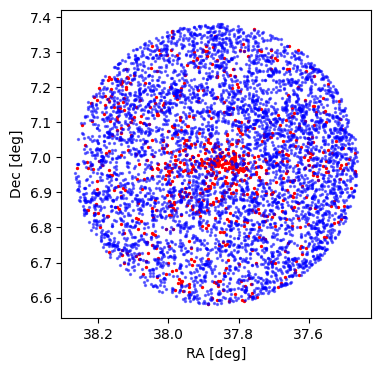

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(obj_cat["coord_ra"][sel_rs],
           obj_cat["coord_dec"][sel_rs],
           s=2., color='red')
ax.scatter(obj_cat["coord_ra"][sel_bg],
           obj_cat["coord_dec"][sel_bg],
           s=2., alpha=0.5, color='blue')
ax.invert_xaxis()
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
plt.show()

> **Figure 3:** The 2D distribution of RS (red) and background (blue) galaxies.

### 3.5. Mark galaxies on the deep coadd

For background (RS) galaxies that overlap the `deep_coadd` image displayed in Firefly, mark them on the image with an blue (red) circle. Those bright large cluster galaxies are the RS galaxies. The background galaxies are smaller and fainter visually. 

In [17]:
bbox = deep_coadd.getBBox()

In [18]:
sel_inside = obj_cat["x"][sel_bg] < (bbox.getMaxX()-100)
sel_inside &= obj_cat["y"][sel_bg] < (bbox.getMaxY()-100)
sel_inside &= obj_cat["x"][sel_bg] > (bbox.getMinX()+100)
sel_inside &= obj_cat["y"][sel_bg] > (bbox.getMinY()+100)
with afw_display.Buffering():
    for obj in obj_cat[sel_bg][sel_inside]:
        afw_display.dot("o", obj["x"], obj["y"], size=20, ctype="blue")

In [19]:
sel_inside = obj_cat["x"][sel_rs] < (bbox.getMaxX()-100)
sel_inside &= obj_cat["y"][sel_rs] < (bbox.getMaxY()-100)
sel_inside &= obj_cat["x"][sel_rs] > (bbox.getMinX()+100)
sel_inside &= obj_cat["y"][sel_rs] > (bbox.getMinY()+100)
with afw_display.Buffering():
    for obj in obj_cat[sel_rs][sel_inside]:
        afw_display.dot("o", obj["x"], obj["y"], size=20, ctype="red")

## 4. Lensing analysis

WL distorts galaxy shapes, which are described by ellipticity. The ellipticity is constructed from the second moments of the object's 2D flux distribution, corrected for PSF effects. 
The HSM shape measurement is available in the catalog. The details of HSM are described in the work of [Hirata and Seljak (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract) and [Mandelbaum et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract). 

Require the measured ellipticity to be within 2. This removes galaxies with very large measured ellipticities that are unphysical, but allows galaxies with measured ellipticities slightly larger than 1 caused by noise ([Mandelbaum et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). 

For HSM shapes, the mean ellipticity divided by 2 approximates the lensing shear. Between the measured shear and the true shear there is a small bias, which is caused by galaxy shape dispersion, measurement noise, pixelization, and other effects. Usually, a shear calibration corrects for this bias. However, accurately determining shear calibration parameters requires further image simulation, which is beyond the scope of this notebook. Thus, for demonstration, skip shear calibration but focus on studying the mean galaxy shape in this notebook.

Perform quality cuts on the background galaxy sample for lensing analysis ([Mandelbaum et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)).

In [20]:
sel_bg &= np.sqrt(obj_cat[f'{band_shape}_hsmShapeRegauss_e1']**2 + \
                  obj_cat[f'{band_shape}_hsmShapeRegauss_e2']**2) < 2
sel_bg &= obj_cat[f'{band_shape}_hsmShapeRegauss_sigma'] <= 0.4
sel_bg &= obj_cat[f'{band_shape}_hsmShapeRegauss_flag'] == False
sel_bg &= obj_cat[f'{band_shape}_blendedness'] < 0.42

Get the background galaxy sample.

In [21]:
obj_cat_bg = obj_cat[sel_bg]

Compute the tangential and cross ellipticities of background galaxies with respect to the cluster center. 

In the following formulae, $e_\textrm{T}$ is the tangential ellipticity, $e_\textrm{X}$ is the cross ellipticity, $\varphi$ is the position angle towards the cluster center (top North and left East), $e_1$ and $e_2$ are the original ellipticity components. Note, in the formulae the position angle starts from the negative RA direction (West) and increases counterclockwise, but in Astropy the position angle starts from North. Thus, add $\pi/2$ to the position angle computed by Astropy. 

$e_\textrm{T}= - e_1 \cos(2 \varphi)- e_2 \sin(2 \varphi)$

$e_\textrm{X}= e_1 \sin(2 \varphi) - e_2 \cos(2 \varphi)$

Here, the tangential direction is perpendicular to the line connecting the galaxy and the cluster center, while the cross direction is 45 degrees counterclockwise from the tangential direction.  

Also, compute the radial distance in arcminutes.

In [22]:
e1 = obj_cat_bg[f'{band_shape}_hsmShapeRegauss_e1']
e2 = obj_cat_bg[f'{band_shape}_hsmShapeRegauss_e2']

center_ra = ra_bcg
center_dec = dec_bcg
ra = obj_cat_bg["coord_ra"]
dec = obj_cat_bg["coord_dec"]

coord0 = SkyCoord(center_ra, center_dec, frame='icrs', unit='deg')
coord1 = SkyCoord(ra, dec, frame='icrs', unit='deg')

position_angle = coord0.position_angle(coord1).rad + np.pi/2.

e_t = - e1 * np.cos(2.*position_angle) - e2 * np.sin(2.*position_angle)
e_x = + e1 * np.sin(2.*position_angle) - e2 * np.cos(2.*position_angle)

r = coord0.separation(coord1).arcmin

Examine the distributions of the tangential and cross ellipticities. They both show Gaussian-like distributions, but the tangential ellipticity distribution has a mean slightly above zero, while the cross ellipticity distribution has a mean close to zero ([Kaiser 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...439L...1K/abstract); [Umetsu 2020](https://ui.adsabs.harvard.edu/abs/2020A%26ARv..28....7U/abstract)). 

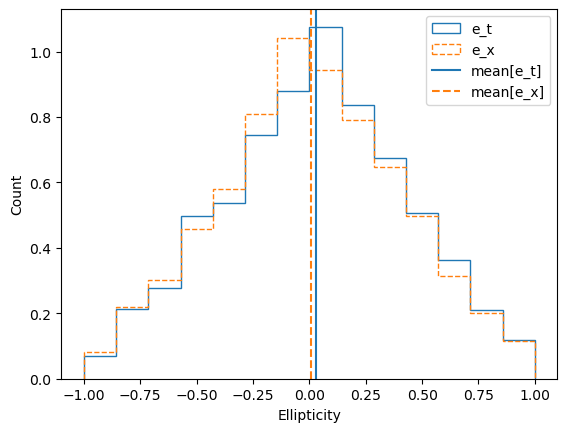

In [23]:
bins = np.linspace(-1, 1, 15)
mid = 0.5 * (bins[1:] + bins[:-1])

plt.figure()

n_e_t, _, im = plt.hist(e_t, bins=bins, histtype='step',
                        density=True, label='e_t')
n_e_x, _, im = plt.hist(e_x, bins=bins, histtype='step',
                        density=True, ls='--', label='e_x')

plt.axvline(np.mean(e_t), color='C0', label='mean[e_t]')
plt.axvline(np.mean(e_x), color='C1', ls='--', label='mean[e_x]')

plt.xlabel('Ellipticity')
plt.ylabel('Count')

_ = plt.legend()

> **Figure 4:** Distributions of the tangential ellipticities and the cross ellipticities of the selected background galaxies.

The difference between two distributions shows a dipole feature -- this is caused by weak lensing, which slightly distorts the galaxy shapes along the tangential direction and leads to a small offset of the distribution peak. See also an example in the work of [Dell'Antonio et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...903...64D/abstract).

Text(0, 0.5, 'Count difference')

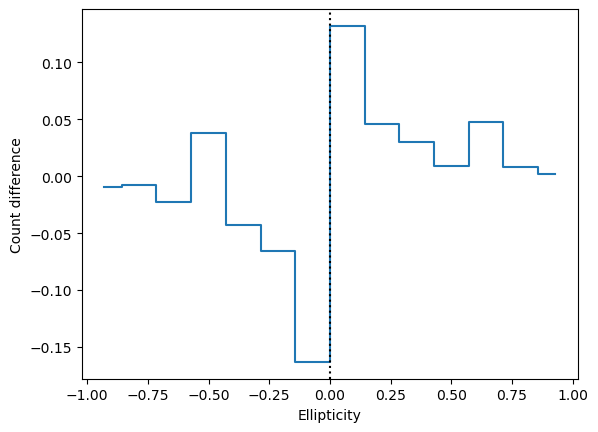

In [24]:
plt.figure()
plt.step(mid, n_e_t - n_e_x, where='mid')
plt.axvline(0, color='k', ls=':')
plt.xlabel('Ellipticity')
plt.ylabel('Count difference')

> **Figure 5:** Difference between the distributions of the tangential ellipticities and the cross ellipticities.

Bin the data by radial distance to get the mean tangential and cross ellipticities. Note, these are ellipticity profiles rather than shear profiles. 

Estimate the error bar by the standard deviation divided by the square root of the number of data points  ($std/\sqrt{N}$). Here, the shape noise (which can be as large as the ellipticity itself) is usually about 10 times bigger than other sources of error (e.g., the large-scale structure can affect the measurement of the cluster lensing signal). Therefore, using the statistical error is sufficient in this case, assuming each galaxy's shape is an independent measurement. 

When plotting the cross component result, shift the data point slightly for better visualization. 

23.99599303522469


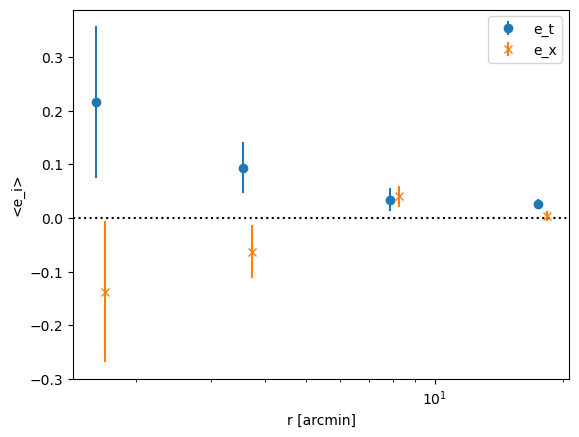

In [25]:
r_max = np.max(r)
print(r_max)

bins = np.logspace(np.log10(1), np.log10(r_max), 5)
mid = 0.5 * (bins[1:] + bins[:-1])

e_t_mean, _, _ = binned_statistic(r, e_t, bins=bins)
e_x_mean, _, _ = binned_statistic(r, e_x, bins=bins)

e_t_std, _, _ = binned_statistic(r, e_t, bins=bins,
                                 statistic='std')
e_x_std, _, _ = binned_statistic(r, e_x, bins=bins,
                                 statistic='std')

count, _, _ = binned_statistic(r, e_t, bins=bins,
                               statistic='count')

e_t_err = e_t_std / count ** 0.5
e_x_err = e_x_std / count ** 0.5

plt.figure()
plt.errorbar(mid, e_t_mean, e_t_err, fmt='o', label='e_t')
plt.errorbar(mid*1.05, e_x_mean, e_x_err, fmt='x', label='e_x')
plt.axhline(0, color='k', ls=':')
plt.gca().set_xscale('log')
plt.xlabel('r [arcmin]')
plt.ylabel('<e_i>')

_ = plt.legend()

> **Figure 6**: Mean shape profile with error bars estimated by statistical uncertainty.

Figure 6 shows that this cluster has sufficient mass to produce a significant lensing signal (mean tangential ellipticity) and the signal is stronger near the cluster center, which is good. 
Additionally, Figure 6 shows that the mean cross ellipticity is consistent with zero, indicating no significant systematics (as expected). 

## 5. Exercises for the learner

- Similar to the analysis of background sources here, test the shape distribution of cluster member galaxies, using the RS selection described above. Both the mean tangential and cross ellipticities are expected to be zero, because there is no lensing effect on cluster galaxies. The member galaxies may exist a small alightment due to gravity (instrinsic alignment), but this effect is much smaller than lensing.
- Repeat the notebook but use `r` as the selected band (instead of the `i` band in this tutorial) for the lensing analysis, and test whether the final plot looks like the `i` band result (they should be generally consistent because lensing effect is independent of color). 

Note: It is encouraged that researchers join the LSST Dark Energy Science Collaboration (DESC) to carry out cosmological studies using the Rubin data.